In [1]:
%load_ext autoreload
%autoreload 2
from data_util import *
from metric_util import *
from train_util import *
from model import *

import torch 
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from torchvision import transforms
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
#sys.path.append('./PyGCL')
import GCL.losses as L
from GCL.models import DualBranchContrast
from GCL.eval import get_split, LREvaluator, SVMEvaluator


In [2]:
config = {
    # meta config
    'dataset_name': 'adult',
    'sens_name': 'gender',
    'conditional': False,
    'debias': False,
    'adversarial': False,
    # tunable config
    'batch_size': 1024*7,
    'hidden_dim': 240,
    'drop_prob': 0.2,
    'cond_temp': 1.0/200,
    'debias_temp': 1.0/30,
    'debias_ratio': 4,
    'lr': 0.00005,
    'tau': 0.1,
}


In [2]:
# config from ray trial
config = {'dataset_name': 'adult',
 'sens_name': 'gender',
 'conditional': True,
 'debias': True,
 'adversarial': False,
 'batch_size': 5120,
 'hidden_dim': 220,
 'drop_prob': 0.23526761349095193,
 'cond_temp': 1/400,
 'debias_temp': 0.05464262537638573,
 'debias_ratio': 3.5787353988820394,
 'lr': 6.778680409743423e-06,
 'tau': 0.1}

In [4]:
# config for celeba gender from ray
config = {'dataset_name': 'celeba', 'sens_name': 'gender', 'conditional': False, 'debias': False, 'adversarial': False, 'batch_size': 1024, 'hidden_dim': 200, 'drop_prob': 0.21933711406450526, 'cond_temp': 0.004580936862279113, 'debias_temp': 0.014837335160686837, 'debias_ratio': 5.895037428868658, 'lr': 0.00020992489648128816, 'tau': 0.050515329052622834}

In [3]:
# some more config setting
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

dataset_name = config['dataset_name']
sens_name = config['sens_name']
sens_num = 2 if sens_name=='gender' else 1
TASK_TYPE = 'regression' if dataset_name=='crimes' else 'classification'

In [4]:
# load dataset...
dataset = get_dataset(dataset_name, sens_name)
x, sens = get_samples(dataset, num=5000)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)

In [5]:
# prepare model config
input_dim = dataset[0][0].shape[-1]
hidden_dim = config['hidden_dim'] if dataset_name != 'celeba' else 1000
sens_dim = dataset.sens_dim

In [6]:
# create model
mlp_main = MLP(input_dim, hidden_dim) if dataset_name != 'celeba' else RES()
mlp_sens = MLP(sens_dim,hidden_dim)
adv_model = Adv_sens(sens_num=sens_num, hidden_dim=hidden_dim)

aug = FeatureDrop(drop_prob=config['drop_prob']) if dataset_name != 'celeba' else transforms.Compose([transforms.RandomCrop(size=RESIZE), transforms.ColorJitter(),
                         transforms.Grayscale(num_output_channels=3), transforms.RandomHorizontalFlip(),
                         transforms.RandomVerticalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#FeatureDrop(drop_prob=config['drop_prob'])

encoder_model = Encoder(main_encoder = mlp_main, augmentor = aug, sens_encoder = mlp_sens, adv_model=adv_model)
encoder_model = encoder_model.to(device)

In [9]:
contrast_model = DualBranchContrast(loss=L.FairInfoNCE(tau=config['tau']), mode='G2G').to(device)
optim = Adam(encoder_model.parameters(), lr=config['lr'])

performance_list = []
hist_gdp_list = []
max_gdp_list = []
kernel_gdp_list = []

(epoch_num,interval) = (400,40) if dataset_name!='celeba' else (10,1)

with tqdm(total=epoch_num, desc='(T)') as pbar:
    for epoch in range(1, epoch_num+1):
        encoder_model = encoder_model.to(device)
        loss_result = train(encoder_model = encoder_model, contrast_model=contrast_model,
                                         dataloader=dataloader, optimizer = optim,
                                         conditional=config['conditional'],debias=config['debias'], adversarial=config['adversarial'] if epoch%5==0 else False,
                                         cond_temp = config['cond_temp'],
                                         debias_temp = config['debias_temp'],
                                         debias_ratio = config['debias_ratio'])
        pbar.set_postfix({'loss': loss_result['loss'], 
                          'conditional_loss':loss_result['conditional_loss'], 
                          'debias_loss': loss_result['debias_loss'],
                          'adv_loss': loss_result['adv_loss']})
        pbar.update()

        if epoch % interval == 0:
            print(loss_result)
            result, evaluator = test(encoder_model, dataloader, evaluator=LREvaluator(task=TASK_TYPE))
            #result, evaluator = test(encoder_model, dataloader, evaluator=SVMEvaluator())
            classifier = result['classifier']
            
            # performance 
            performance = result['mae'] if dataset_name=='crimes' else result['auc']
            print('performance: ', performance)
            performance_list.append(performance)

            # fairness
            gdp_hist, gdp_kernel, gdp_max = gdp(dataset=dataset, task=TASK_TYPE, hist_num=1000, encoder_model=encoder_model, classifier=classifier, x=x, sens=sens)
            print('hist gdp: ', gdp_hist)
            hist_gdp_list.append(gdp_hist)
            print('max gdp: ', gdp_max)
            max_gdp_list.append(gdp_max)
            print('kernel gdp: ', gdp_kernel)
            kernel_gdp_list.append(gdp_kernel)
            #print(' auc: ', result['auc'], ' dp: ', dp)

(T):   2%|▏         | 40/2000 [01:02<50:42,  1.55s/it, loss=3.95, conditional_loss=3.64, debias_loss=0.0861, adv_loss=0]

{'loss': 3.9513311915927463, 'conditional_loss': 3.6432226763831244, 'debias_loss': 0.0860942511094941, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.837, F1Ma=0.769]


performance:  0.7549535357924821
hist gdp:  0.07877015999999998
max gdp:  0.18393272349146517
kernel gdp:  0.0772036


(T):   4%|▍         | 80/2000 [02:15<49:45,  1.56s/it, loss=3.67, conditional_loss=3.42, debias_loss=0.0703, adv_loss=0]  

{'loss': 3.670195950402154, 'conditional_loss': 3.4186513423919678, 'debias_loss': 0.07028867221540874, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.84, F1Ma=0.773]


performance:  0.7588268167178939
hist gdp:  0.07566712000000003
max gdp:  0.17668695176391047
kernel gdp:  0.0741623


(T):   6%|▌         | 120/2000 [03:27<48:41,  1.55s/it, loss=3.45, conditional_loss=3.25, debias_loss=0.0564, adv_loss=0] 

{'loss': 3.453966803020901, 'conditional_loss': 3.252102772394816, 'debias_loss': 0.05640652858548694, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.838, F1Ma=0.769]


performance:  0.7559236947791164
hist gdp:  0.07653679999999996
max gdp:  0.17871770314192037
kernel gdp:  0.07501466


(T):   8%|▊         | 160/2000 [04:40<47:39,  1.55s/it, loss=3.29, conditional_loss=3.11, debias_loss=0.0487, adv_loss=0]  

{'loss': 3.2853598594665527, 'conditional_loss': 3.111080275641547, 'debias_loss': 0.048698643015490636, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.836, F1Ma=0.768]


performance:  0.7542274638586803
hist gdp:  0.07855192000000003
max gdp:  0.18342312090115964
kernel gdp:  0.07698971


(T):  10%|█         | 200/2000 [05:54<46:32,  1.55s/it, loss=3.15, conditional_loss=2.99, debias_loss=0.0429, adv_loss=0]  

{'loss': 3.145166370603773, 'conditional_loss': 2.991603003607856, 'debias_loss': 0.04290996202164226, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.844, F1Ma=0.774]


performance:  0.7603483024562988
hist gdp:  0.07842767999999997
max gdp:  0.18313301356144396
kernel gdp:  0.07686794


(T):  12%|█▏        | 240/2000 [07:07<46:10,  1.57s/it, loss=3.06, conditional_loss=2.91, debias_loss=0.04, adv_loss=0]    

{'loss': 3.0563337008158364, 'conditional_loss': 2.913145833545261, 'debias_loss': 0.04001076022783915, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.849, F1Ma=0.784]


performance:  0.7700294165482227
hist gdp:  0.08114584000000005
max gdp:  0.18948006899062642
kernel gdp:  0.07953205


(T):  14%|█▍        | 280/2000 [08:20<44:45,  1.56s/it, loss=2.93, conditional_loss=2.8, debias_loss=0.0346, adv_loss=0]   

{'loss': 2.9280032316843667, 'conditional_loss': 2.804353396097819, 'debias_loss': 0.03455126244160864, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.834, F1Ma=0.766]


performance:  0.7516705974842768
hist gdp:  0.0807458400000001
max gdp:  0.18854604664769115
kernel gdp:  0.07913999


(T):  16%|█▌        | 320/2000 [09:34<44:09,  1.58s/it, loss=2.85, conditional_loss=2.74, debias_loss=0.0321, adv_loss=0]  

{'loss': 2.853139559427897, 'conditional_loss': 2.738186756769816, 'debias_loss': 0.032121063520510994, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.843, F1Ma=0.775]


performance:  0.7603146197453006
hist gdp:  0.07635800000000004
max gdp:  0.17830019515462825
kernel gdp:  0.07483941


(T):  18%|█▊        | 360/2000 [10:47<42:26,  1.55s/it, loss=2.78, conditional_loss=2.67, debias_loss=0.0304, adv_loss=0]  

{'loss': 2.7778914239671497, 'conditional_loss': 2.6690060827467175, 'debias_loss': 0.030425649757186573, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.847, F1Ma=0.78]


performance:  0.764677903142447
hist gdp:  0.07942160000000001
max gdp:  0.18545387227916954
kernel gdp:  0.0778421


(T):  20%|██        | 400/2000 [12:00<41:45,  1.57s/it, loss=2.71, conditional_loss=2.62, debias_loss=0.0269, adv_loss=0]  

{'loss': 2.7118468284606934, 'conditional_loss': 2.615735901726617, 'debias_loss': 0.026856103911995888, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.844, F1Ma=0.772]


performance:  0.7576120321971841
hist gdp:  0.07882767999999993
max gdp:  0.18406703590437923
kernel gdp:  0.07725999


(T):  22%|██▏       | 440/2000 [13:12<40:46,  1.57s/it, loss=2.67, conditional_loss=2.58, debias_loss=0.0251, adv_loss=0]  

{'loss': 2.665682978100247, 'conditional_loss': 2.575815041859945, 'debias_loss': 0.025111638630429905, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.843, F1Ma=0.778]


performance:  0.7640852403283285
hist gdp:  0.07666104000000001
max gdp:  0.17900781048163605
kernel gdp:  0.07513643


(T):  24%|██▍       | 480/2000 [14:25<39:10,  1.55s/it, loss=2.61, conditional_loss=2.53, debias_loss=0.0243, adv_loss=0]  

{'loss': 2.614937278959486, 'conditional_loss': 2.528028885523478, 'debias_loss': 0.024284665369325213, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.844, F1Ma=0.781]


performance:  0.7697772055530676
hist gdp:  0.07870640000000001
max gdp:  0.18378384033000128
kernel gdp:  0.07714113


(T):  26%|██▌       | 520/2000 [15:38<39:01,  1.58s/it, loss=2.56, conditional_loss=2.48, debias_loss=0.0221, adv_loss=0]  

{'loss': 2.558820221159193, 'conditional_loss': 2.4799029297298856, 'debias_loss': 0.02205171932776769, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.843, F1Ma=0.777]


performance:  0.7672351766120405
hist gdp:  0.07773976000000005
max gdp:  0.18152668193606392
kernel gdp:  0.076193705


(T):  28%|██▊       | 560/2000 [16:51<38:53,  1.62s/it, loss=2.52, conditional_loss=2.44, debias_loss=0.0225, adv_loss=0]  

{'loss': 2.5212822490268283, 'conditional_loss': 2.440740876727634, 'debias_loss': 0.022505532536241744, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.843, F1Ma=0.774]


performance:  0.7566922122974017
hist gdp:  0.07666104000000001
max gdp:  0.17900781048163605
kernel gdp:  0.07513644


(T):  30%|███       | 600/2000 [18:03<37:09,  1.59s/it, loss=2.48, conditional_loss=2.41, debias_loss=0.0215, adv_loss=0]  

{'loss': 2.484514501359728, 'conditional_loss': 2.4074680275387235, 'debias_loss': 0.021528977072901197, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.847, F1Ma=0.788]


performance:  0.7739928909952607
hist gdp:  0.07754584000000012
max gdp:  0.18107386790420898
kernel gdp:  0.07600363


(T):  32%|███▏      | 640/2000 [19:16<35:47,  1.58s/it, loss=2.45, conditional_loss=2.38, debias_loss=0.0197, adv_loss=0]  

{'loss': 2.454306549496121, 'conditional_loss': 2.3838477664523654, 'debias_loss': 0.01968817102412383, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.842, F1Ma=0.777]


performance:  0.7636906871114261
hist gdp:  0.07725496000000007
max gdp:  0.18039464685642637
kernel gdp:  0.07571852


(T):  34%|███▍      | 680/2000 [20:29<34:03,  1.55s/it, loss=2.42, conditional_loss=2.35, debias_loss=0.0192, adv_loss=0]  

{'loss': 2.4194014072418213, 'conditional_loss': 2.350541830062866, 'debias_loss': 0.019241316864887874, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.839, F1Ma=0.77]


performance:  0.7538485174552758
hist gdp:  0.07769736000000008
max gdp:  0.18142767556771278
kernel gdp:  0.07615215


(T):  36%|███▌      | 720/2000 [21:42<33:14,  1.56s/it, loss=2.39, conditional_loss=2.33, debias_loss=0.0182, adv_loss=0]  

{'loss': 2.3907674153645835, 'conditional_loss': 2.325458844502767, 'debias_loss': 0.018249071203172207, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.85, F1Ma=0.783]


performance:  0.7683652265253929
hist gdp:  0.07528224000000006
max gdp:  0.17578823546553823
kernel gdp:  0.07378505


(T):  38%|███▊      | 760/2000 [22:54<32:26,  1.57s/it, loss=2.35, conditional_loss=2.29, debias_loss=0.0174, adv_loss=0]  

{'loss': 2.3541521231333413, 'conditional_loss': 2.291775359047784, 'debias_loss': 0.017429825125469103, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.846, F1Ma=0.782]


performance:  0.7699825240360502
hist gdp:  0.07663671999999999
max gdp:  0.17895102192318557
kernel gdp:  0.07511261


(T):  40%|████      | 800/2000 [24:07<31:36,  1.58s/it, loss=2.36, conditional_loss=2.3, debias_loss=0.0176, adv_loss=0]   

{'loss': 2.362803988986545, 'conditional_loss': 2.2997545931074352, 'debias_loss': 0.017617781853510275, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.847, F1Ma=0.785]


performance:  0.7685484334302014
hist gdp:  0.0759034400000001
max gdp:  0.17723877216411676
kernel gdp:  0.07439391


(T):  42%|████▏     | 840/2000 [25:21<30:42,  1.59s/it, loss=2.34, conditional_loss=2.28, debias_loss=0.0165, adv_loss=0]  

{'loss': 2.3400703271230063, 'conditional_loss': 2.2808558411068387, 'debias_loss': 0.016546197339064546, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.849, F1Ma=0.786]


performance:  0.7706028884908196
hist gdp:  0.07692464000000007
max gdp:  0.17962333120563045
kernel gdp:  0.07539478


(T):  44%|████▍     | 880/2000 [26:34<29:07,  1.56s/it, loss=2.31, conditional_loss=2.25, debias_loss=0.016, adv_loss=0]   

{'loss': 2.3110753430260553, 'conditional_loss': 2.253816392686632, 'debias_loss': 0.01599976648059156, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.849, F1Ma=0.787]


performance:  0.7717887292797263
hist gdp:  0.07707616000000003
max gdp:  0.17997713886913425
kernel gdp:  0.07554329


(T):  46%|████▌     | 920/2000 [27:46<28:05,  1.56s/it, loss=2.29, conditional_loss=2.24, debias_loss=0.0154, adv_loss=0]  

{'loss': 2.293880409664578, 'conditional_loss': 2.238644599914551, 'debias_loss': 0.015434439811441634, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:09<00:00, best test F1Mi=0.849, F1Ma=0.784]


performance:  0.7684860035782846
hist gdp:  0.07644280000000006
max gdp:  0.17849820789133064
kernel gdp:  0.074922524


(T):  47%|████▋     | 937/2000 [28:23<28:07,  1.59s/it, loss=2.3, conditional_loss=2.24, debias_loss=0.0158, adv_loss=0]   

In [9]:
ray_result = torch.load('adult_age_ray_config_result')

In [19]:
x, sens = get_samples(dataset, num=5000)

In [20]:
sum(sens.numpy())

array([2090])

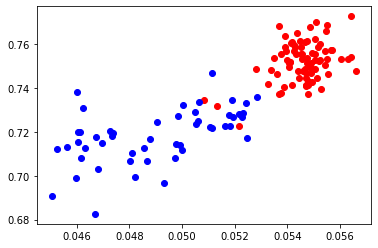

In [11]:
plt.scatter(kernel_gdp_list, performance_list, color = 'red')
plt.scatter(ray_result['kernel_gdp_list'], ray_result['performance_list'], color = 'blue')

In [ ]:
(T):  10%|█         | 1/10 [02:56<26:26, 176.33s/it, loss=3.31, conditional_loss=3.31, debias_loss=0, adv_loss=0]{'loss': 3.3105884914128287, 'conditional_loss': 3.3105884914128287, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.722, F1Ma=0.627]
performance:  0.6215321238170274
hist gdp:  0.017824879999999987
max gdp:  0.036591183832224816
kernel gdp:  0.01747832
(T):  20%|██        | 2/10 [06:49<27:58, 209.78s/it, loss=1.2, conditional_loss=1.2, debias_loss=0, adv_loss=0]  {'loss': 1.2037508939422152, 'conditional_loss': 1.2037508939422152, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.724, F1Ma=0.626]
performance:  0.6197896351154141
hist gdp:  0.003113199999999927
max gdp:  0.006390824146164431
kernel gdp:  0.0030526735
(T):  30%|███       | 3/10 [10:41<25:40, 220.06s/it, loss=0.602, conditional_loss=0.602, debias_loss=0, adv_loss=0]{'loss': 0.6021230984596336, 'conditional_loss': 0.6021230984596336, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.723, F1Ma=0.629]
performance:  0.6226530693897584
hist gdp:  0.00046783999999994164
max gdp:  0.0009603890429594752
kernel gdp:  0.00045875457
(T):  40%|████      | 4/10 [14:34<22:30, 225.06s/it, loss=0.365, conditional_loss=0.365, debias_loss=0, adv_loss=0]{'loss': 0.3646215566861554, 'conditional_loss': 0.3646215566861554, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.721, F1Ma=0.609]
performance:  0.607438862026335
hist gdp:  0.004117119999999974
max gdp:  0.00845168633838378
kernel gdp:  0.0040370813
(T):  50%|█████     | 5/10 [18:28<19:01, 228.29s/it, loss=0.247, conditional_loss=0.247, debias_loss=0, adv_loss=0]{'loss': 0.24697424630698916, 'conditional_loss': 0.24697424630698916, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.726, F1Ma=0.64]
performance:  0.6320688959634982
hist gdp:  0.017640800000000012
max gdp:  0.03621330161816033
kernel gdp:  0.017297806
(T):  60%|██████    | 6/10 [22:26<15:25, 231.41s/it, loss=0.195, conditional_loss=0.195, debias_loss=0, adv_loss=0]{'loss': 0.19505906526772482, 'conditional_loss': 0.19505906526772482, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.719, F1Ma=0.602]
performance:  0.6024729446223019
hist gdp:  0.021214320000000023
max gdp:  0.04354907763730498
kernel gdp:  0.020801848
(T):  70%|███████   | 7/10 [26:19<11:36, 232.03s/it, loss=0.156, conditional_loss=0.156, debias_loss=0, adv_loss=0]{'loss': 0.15644739872816973, 'conditional_loss': 0.15644739872816973, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.719, F1Ma=0.596]
performance:  0.5965043916591223
hist gdp:  0.010264080000000002
max gdp:  0.02107025899465595
kernel gdp:  0.010064515
(T):  80%|████████  | 8/10 [30:11<07:44, 232.18s/it, loss=0.141, conditional_loss=0.141, debias_loss=0, adv_loss=0]{'loss': 0.1410486141465745, 'conditional_loss': 0.1410486141465745, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.716, F1Ma=0.59]
performance:  0.5926175157903203
hist gdp:  0.013655040000000007
max gdp:  0.0280312730787744
kernel gdp:  0.013389545
(T):  90%|█████████ | 9/10 [34:04<03:52, 232.49s/it, loss=0.122, conditional_loss=0.122, debias_loss=0, adv_loss=0]{'loss': 0.1224909244843249, 'conditional_loss': 0.1224909244843249, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.714, F1Ma=0.588]
performance:  0.5909408460459336
hist gdp:  0.027953040000000012
max gdp:  0.057382424190767944
kernel gdp:  0.027409546
(T): 100%|██████████| 10/10 [37:59<00:00, 233.14s/it, loss=0.111, conditional_loss=0.111, debias_loss=0, adv_loss=0]{'loss': 0.11095712408892014, 'conditional_loss': 0.11095712408892014, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.715, F1Ma=0.588]
performance:  0.5911484300807217
hist gdp:  0.010051999999999998
max gdp:  0.0206348979562008
(T): 100%|██████████| 10/10 [38:56<00:00, 233.64s/it, loss=0.111, conditional_loss=0.111, debias_loss=0, adv_loss=0]kernel gdp:  0.0098565575